# Phase 1 & 2 Progress Demo
This notebook shows the upgraded data layer utilities (Phase 1) and the first batch of core signals (Phase 2).

In [7]:
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]
%pip install -q -e {repo_root}

Note: you may need to restart the kernel to use updated packages.


In [8]:
import sys, pathlib

repo_root = pathlib.Path.cwd().resolve().parents[1]  # .../tf_trend_repo
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))


from tf.data import load_prices_or_generate
from tf.signals import timeseries_momentum, price_vs_sma, channel_breakout
from tf.portfolio.sizing import volatility_target_positions
from tf.engine.backtester import Backtester

universe = [
    {"symbol": "ES", "sector": "Equities", "point_value": 50},
    {"symbol": "CL", "sector": "Commodities", "point_value": 1000},
]
prices = load_prices_or_generate(universe, "2015-01-01", "2016-12-31", seed=7)
prices.tail()

Failed to get ticker 'CL=F' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'ES=F' reason: Expecting value: line 1 column 1 (char 0)

2 Failed downloads:
['CL=F', 'ES=F']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ES,CL
2016-12-26,52.549497,111.977643
2016-12-27,52.158777,113.133379
2016-12-28,52.135320,113.106193
2016-12-29,51.829860,115.526686
2016-12-30,51.456773,112.842236


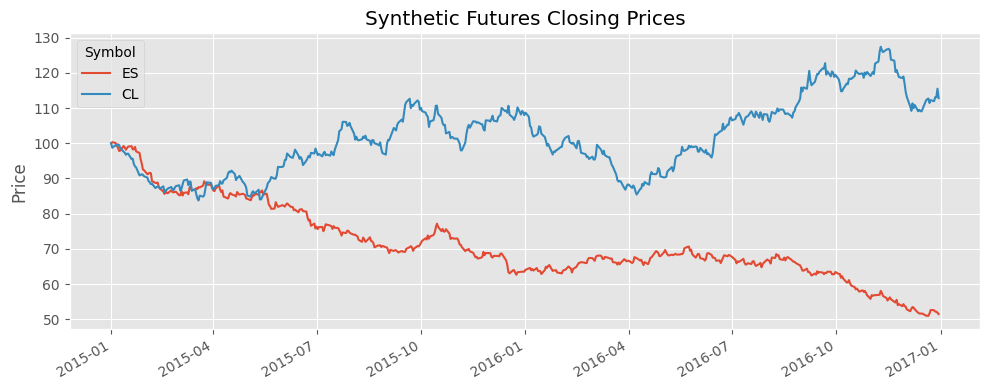

In [9]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 4))
prices.plot(ax=ax)
ax.set_title('Synthetic Futures Closing Prices')
ax.set_ylabel('Price')
ax.legend(title='Symbol', loc='upper left')
plt.tight_layout()

In [10]:
momentum = timeseries_momentum(prices, lookbacks=(63, 126), skip_last_n=10)
moving_avg = price_vs_sma(prices, fast=50, slow=150)
breakout = channel_breakout(prices, window=80)
signals = {
    "momentum": momentum,
    "moving_average": moving_avg,
    "breakout": breakout,
}
combined_signals = sum(signals.values()) / len(signals)
combined_signals.tail()

,ES,CL
2016-12-26,-0.074343,-0.031215
2016-12-27,-0.076236,-0.035437
2016-12-28,-0.079642,-0.028757
2016-12-29,-0.079727,-0.029975
2016-12-30,-0.082760,-0.016205


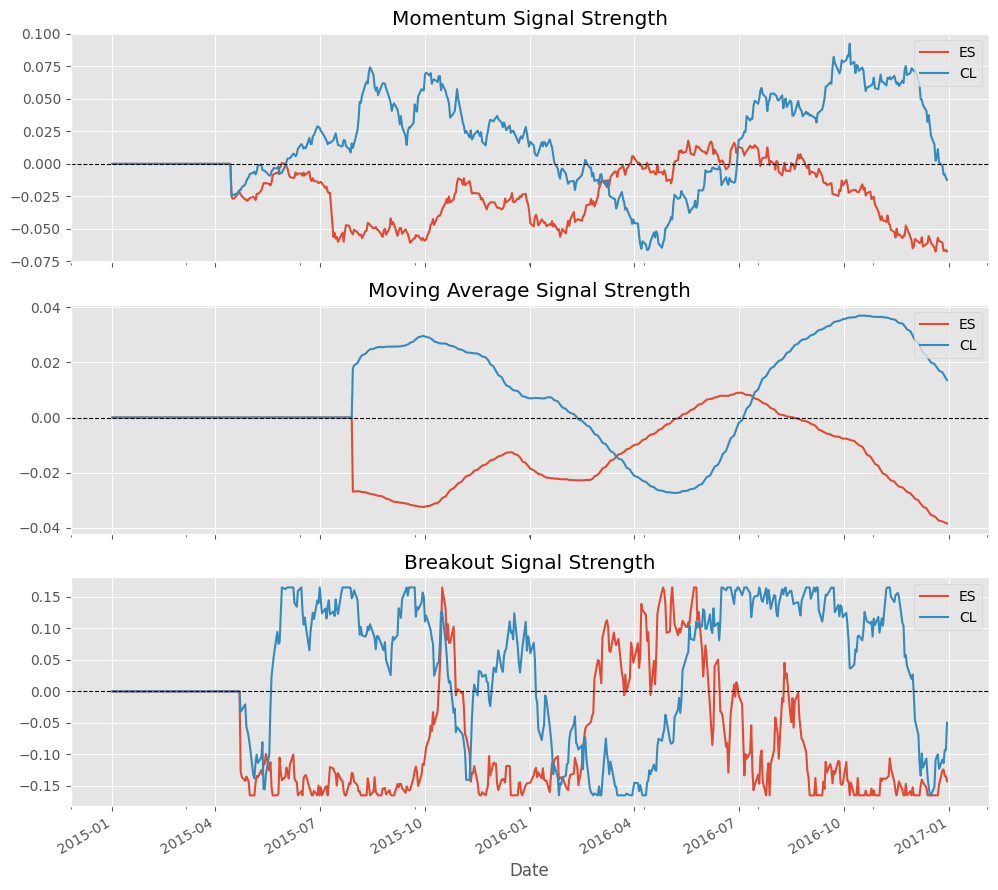

In [11]:
import numpy as np

fig, axes = plt.subplots(len(signals), 1, figsize=(10, 9), sharex=True)
axes = np.atleast_1d(axes)
for ax, (name, signal_df) in zip(axes, signals.items()):
    signal_df.plot(ax=ax)
    ax.set_title(f"{name.replace('_', ' ').title()} Signal Strength")
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()

In [13]:
point_values = {item["symbol"]: item["point_value"] for item in universe}
targets = volatility_target_positions(
    prices,
    momentum,
    point_values,
    target_portfolio_vol=0.15,
    max_position_weight=0.05,
)

targets.tail()

,ES,CL
2016-12-26,-19.0,0.0
2016-12-27,-19.0,-0.0
2016-12-28,-19.0,-0.0
2016-12-29,-19.0,-0.0
2016-12-30,-19.0,-0.0


In [14]:
cfg = {
    "backtest": {"start": "2015-01-01", "end": "2016-12-31", "results_dir": "results/notebooks"},
    "signals": {"momentum": {"lookbacks": [63, 126], "skip_last_n": 10}},
    "risk": {"target_portfolio_vol": 0.15, "max_instrument_vol_weight": 0.05},
    "execution": {"impact": {"k": 0.05, "alpha": 0.5}, "commission_per_contract": 2.5, "tick_value": 10.0}
}
bt = Backtester(prices, universe, cfg)
results = bt.run()
results.nav.tail()

2016-12-26    1.017033e+06
2016-12-27    1.017404e+06
2016-12-28    1.017426e+06
2016-12-29    1.017716e+06
2016-12-30    1.018071e+06
Freq: C, dtype: float64

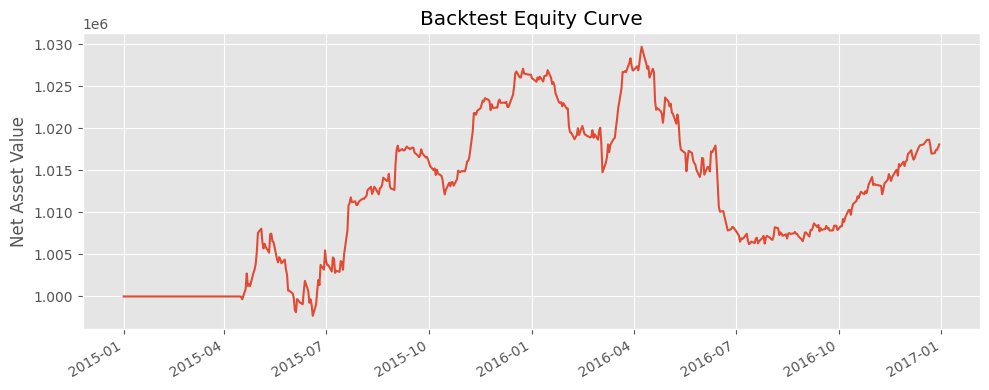

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
results.nav.plot(ax=ax)
ax.set_title('Backtest Equity Curve')
ax.set_ylabel('Net Asset Value')
plt.tight_layout()

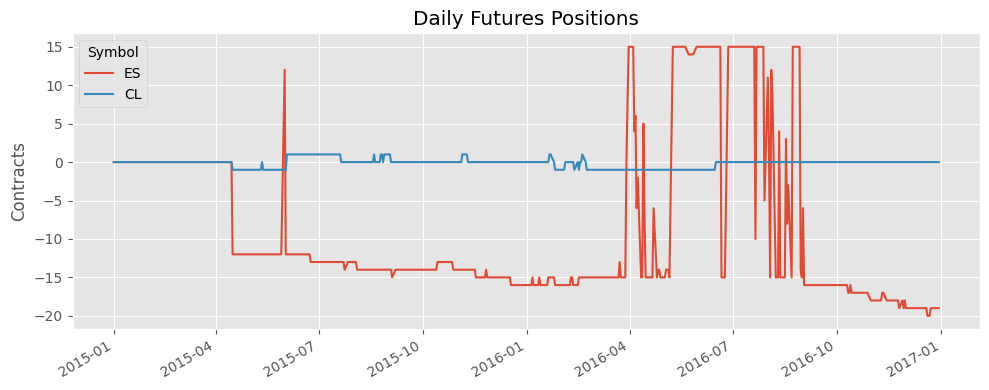

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
results.positions.plot(ax=ax)
ax.set_title('Daily Futures Positions')
ax.set_ylabel('Contracts')
ax.legend(title='Symbol', loc='upper left')
plt.tight_layout()